In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import imblearn
from sklearn.linear_model import LogisticRegression

In [11]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)


In [3]:
data = pd.read_csv('training_data.csv', index_col=0)

In [4]:
data

,message_cur,message_prev,same_user,time_distance,label,mentions_user
0,2011_05_29_18_59_ActionParsnip_999,2011_05_29_18_59_gmachine_24_998,0.0,0.0,0.0,0.0
1,2011_05_29_19_00_Usuario_1000,2011_05_29_18_59_gmachine_24_998,0.0,1.0,0.0,0.0
2,2011_05_29_19_00_EvoGamer_1001,2011_05_29_18_59_gmachine_24_998,0.0,1.0,0.0,0.0
3,2011_05_29_19_00_ActionParsnip_1002,2011_05_29_18_59_gmachine_24_998,0.0,1.0,1.0,1.0
4,2011_05_29_19_00_ActionParsnip_1003,2011_05_29_18_59_gmachine_24_998,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
218492,2005_06_27_12_28_microhaxo_1248,2005_06_27_12_28_microhaxo_1246,1.0,0.0,1.0,0.0
218493,2005_06_27_12_28_microhaxo_1249,2005_06_27_12_28_microhaxo_1246,1.0,0.0,0.0,0.0
218494,2005_06_27_12_28_microhaxo_1248,2005_06_27_12_28_Vassilis_1247,0.0,0.0,0.0,0.0
218495,2005_06_27_12_28_microhaxo_1249,2005_06_27_12_28_Vassilis_1247,0.0,0.0,1.0,0.0


In [5]:
data['label'].value_counts()

0.0    193235
1.0     25262
Name: label, dtype: int64

In [6]:
msk = data['label'] == 1
num_to_oversample = len(data) - 2*msk.sum()
df_positive_oversample = data[msk].sample(n=num_to_oversample, replace=True)
df_train_oversample = pd.concat([data, df_positive_oversample])
df_train_oversample['label'].value_counts()

0.0    193235
1.0    193235
Name: label, dtype: int64

In [7]:
#train_dataset = df_train_oversample.sample(frac=0.75)
#test_dataset = df_train_oversample.drop(train_dataset.index)
train_dataset, test_dataset = train_test_split(df_train_oversample, test_size=0.25, stratify=df_train_oversample['label'])
#X, y = data[['same_user', 'time_distance']].astype('float32'), data['label'].astype('float32')

In [8]:
test_dataset['label'].value_counts()

1.0    48309
0.0    48309
Name: label, dtype: int64

In [23]:
def normalize_col(df, col):
  temp_df = df.copy()
  temp_df[col] = (temp_df[col] - temp_df[col].mean()) / temp_df[col].std()
  return temp_df[col]

In [39]:
column_features = ['same_user', 'time_distance', 'mentions_user']
#column_features = ['same_user']
x_train, y_train = train_dataset[column_features], train_dataset['label']
x_test, y_test = test_dataset[column_features], test_dataset['label']

x_norm_train = x_train.copy()
x_norm_test = x_test.copy()

for col in x_norm_train.columns:
  x_norm_train[col] = normalize_col(x_norm_train, col)
  x_norm_test[col] = normalize_col(x_norm_test, col)

In [40]:
lr_model = LogisticRegression().fit(x_train, y_train)

In [41]:
lr_model.score(x_test, y_test)

0.7513092798443354

In [26]:
lr_model.coef_

array([[ 2.322763  , -0.1429655 ,  3.12736842]])

In [25]:
parameters = {
  'penalty':
}
lr_grid_search = GridSearchCV(LogisticRegression())

In [13]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

In [18]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y, y_classes)
  confusion_normalized = confusion / confusion.sum(axis=1)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

In [15]:
y_pred_train = lr_model.predict(x_train)
train_classes= predict_class(y_pred_train)

In [16]:
y_train

209835    0.0
135106    0.0
207937    1.0
2884      1.0
106435    1.0
         ... 
65197     1.0
170805    1.0
189858    0.0
165728    0.0
33843     1.0
Name: label, Length: 289852, dtype: float64

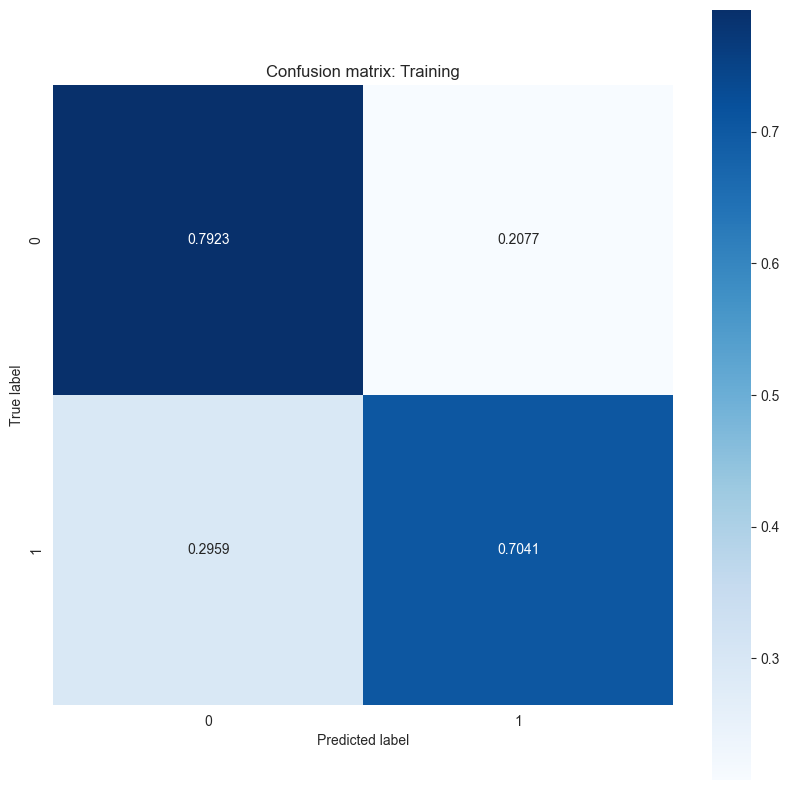

In [19]:
show_confusion_matrix(y_train, train_classes, 'Training')

In [76]:
sk_metrics.confusion_matrix(y_train, train_classes)

array([[102343,  42583],
       [ 38623, 106303]], dtype=int64)

In [20]:
y_pred_test = lr_model.predict(x_test)
test_classes = predict_class(y_pred_test)

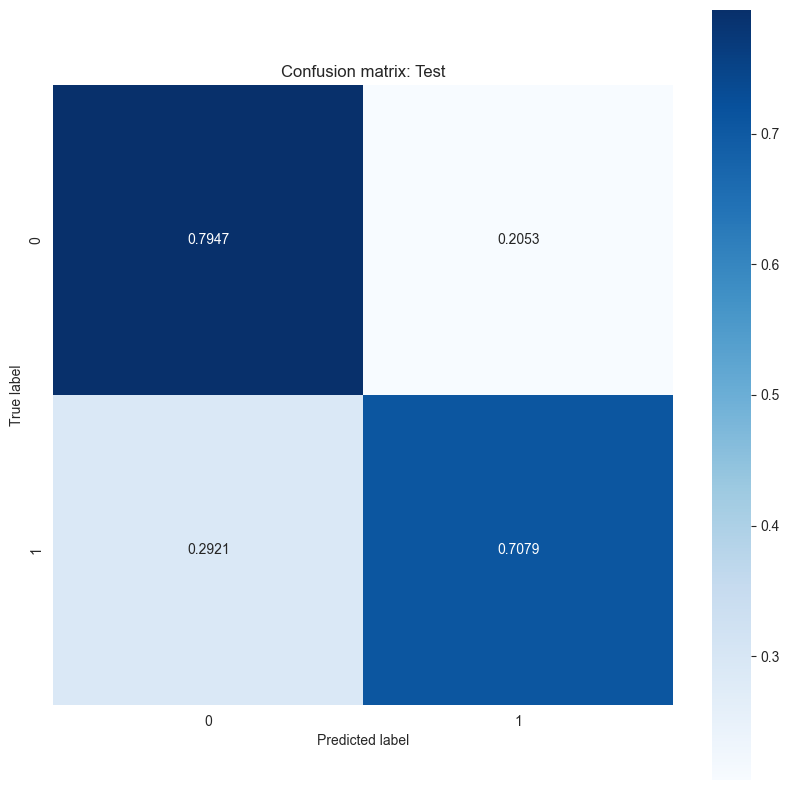

In [21]:
show_confusion_matrix(y_test, test_classes, 'Test')

array([[38527,  9782],
       [14661, 33648]], dtype=int64)

In [53]:
y_test.numpy() - test_classes.numpy()

array([-1.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [54]:
test_classes

<tf.Tensor: shape=(96618,), dtype=float32, numpy=array([1., 1., 1., ..., 0., 1., 1.], dtype=float32)>

### Random Oversampling